# Random Forest
Equus, hisat, genomes.

Use 2M samples.

Save the model.

In [1]:
from datetime import datetime
print(datetime.now())

2023-07-16 12:05:38.310912


In [2]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/IRP2/'  # must end in "/"
    MODEL_DIR=PATH+'My Drive/data/IRP2/'  # must end in "/"
except:
    IN_COLAB = False
    print('Running on Mac')
    DATA_DIR="/Users/jasonmiller/WVU/BAM_ML/"
    MODEL_DIR="/Users/jasonmiller/WVU/BAM_ML/"
SAVE_MODEL_FILENAME = None

GPU device not found
Running on CoLab
Mounted at /content/drive/


In [3]:
from platform import python_version
print('Python',python_version())
import random
import numpy as np
np.random.seed(42) # supposedly sets scikit-learn
import pandas as pd  # for plotting
import time # sleep function
from os.path import isfile
import gzip
from matplotlib import pyplot as plt
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)
import joblib # save & load scikit-learn models

from tensorflow import keras
# consider sklearn.metrics.classification_report
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier as RFC

EPOCHS=150

Python 3.10.12
sklearn 1.2.2


## Data Load

In [4]:
#MAX_LINES_TO_LOAD =    1000000 # training - 1M lines requires 2GB RAM
#MAX_LINES_TO_LOAD =    10000 # use this for debugging
MAX_LINES_TO_LOAD =    2000000

VALID_PORTION = 0.20

DATA_FILE_0 = 'Equus/HiSat/asinus/read_stats.csv.gz'
DATA_FILE_1 = 'Equus/HiSat/caballus/read_stats.csv.gz'
MODEL_FILE = 'Equus/HiSat/RF_153.joblib'

print('Data directory: %s'%DATA_DIR)
print('Data file 0 %s'%DATA_FILE_0)
print('Data file 1 %s'%DATA_FILE_1)
print('Input lines for training: %d'%MAX_LINES_TO_LOAD)
print('Model directory: %s'%MODEL_DIR)
print('Model file: %s'%MODEL_FILE)

Data directory: /content/drive/My Drive/data/IRP2/
Data file 0 Equus/HiSat/asinus/read_stats.csv.gz
Data file 1 Equus/HiSat/caballus/read_stats.csv.gz
Input lines for training: 2000000
Model directory: /content/drive/My Drive/data/IRP2/
Model file: Equus/HiSat/RF_153.joblib


In [5]:
# P1 parent 1
# R1 read 1
# PS primary or secondary
# AS bowtie alignment score (0 is best)
# ED edit distance
# MM mismatch count
# GO gap open count
# GE gap extend count
feature_names = [
    'P1 R1 AS',
    'P1 R1 ED',
    ##'P1 R1 MAT',
    'P1 R1 MM',
    'P1 R1 HQMM',
    'P1 R1 GO',
    'P1 R1 GE',
    'P1 R1 INS',
    'P1 R1 DELS',
    'P1 R1 HQINS',
    'P1 R1 HQDEL',
    'P1 R2 AS',
    'P1 R2 ED',
    ##'P1 R2 MAT',
    'P1 R2 MM',
    'P1 R2 HQMM',
    'P1 R2 GO',
    'P1 R2 GE',
    'P1 R2 INS',
    'P1 R2 DELS',
    'P1 R2 HQINS',
    'P1 R2 HQDEL',
    'P2 R1 AS',
    'P2 R1 ED',
    ##'P2 R1 MAT',
    'P2 R1 MM',
    'P2 R1 HQMM',
    'P2 R1 GO',
    'P2 R1 GE',
    'P2 R1 INS',
    'P2 R1 DELS',
    'P2 R1 HQINS',
    'P2 R1 HQDEL',
    'P2 R2 AS',
    'P2 R2 ED',
    ##'P2 R2 MAT',
    'P2 R2 MM',
    'P2 R2 HQMM',
    'P2 R2 GO',
    'P2 R2 GE',
    'P2 R2 INS',
    'P2 R2 DELS',
    'P2 R2 HQINS',
    'P2 R2 HQDEL',
    ##'R1 length',
    ##'R2 length',
    ##'P1 span',
    ##'P2 span',
    'Span diff',
    'AS diff',
    'ED diff',
    'MAT diff',
    'MM diff',
    'HQMM diff',
    'GO diff',
    'GE diff',
    'INS diff',
    'DELS diff',
    'HQINS diff',
    'HQDEL diff',
    'PARENT']
print('Total feature names: ',len(feature_names))
for i in range(len(feature_names)):
    print(i,feature_names[i])

Total feature names:  53
0 P1 R1 AS
1 P1 R1 ED
2 P1 R1 MM
3 P1 R1 HQMM
4 P1 R1 GO
5 P1 R1 GE
6 P1 R1 INS
7 P1 R1 DELS
8 P1 R1 HQINS
9 P1 R1 HQDEL
10 P1 R2 AS
11 P1 R2 ED
12 P1 R2 MM
13 P1 R2 HQMM
14 P1 R2 GO
15 P1 R2 GE
16 P1 R2 INS
17 P1 R2 DELS
18 P1 R2 HQINS
19 P1 R2 HQDEL
20 P2 R1 AS
21 P2 R1 ED
22 P2 R1 MM
23 P2 R1 HQMM
24 P2 R1 GO
25 P2 R1 GE
26 P2 R1 INS
27 P2 R1 DELS
28 P2 R1 HQINS
29 P2 R1 HQDEL
30 P2 R2 AS
31 P2 R2 ED
32 P2 R2 MM
33 P2 R2 HQMM
34 P2 R2 GO
35 P2 R2 GE
36 P2 R2 INS
37 P2 R2 DELS
38 P2 R2 HQINS
39 P2 R2 HQDEL
40 Span diff
41 AS diff
42 ED diff
43 MAT diff
44 MM diff
45 HQMM diff
46 GO diff
47 GE diff
48 INS diff
49 DELS diff
50 HQINS diff
51 HQDEL diff
52 PARENT


In [6]:
class DataLoader():
    def __init__(self,filepath1,filepath2,verbose=True):
        self.files = [filepath1,filepath2]
        self.alignments=[]
        self.labels=[]
        self.verbose = verbose
        self.max_lines = None
        self.ties = 0
        self.predictions = []
        self.num_features = 1

    def set_num_features(self,count):
        self.num_features = count

    def set_max_lines(self,lines):
        '''Limit the dataset size to fit in RAM.'''
        self.max_lines = lines
        if self.verbose:
            print('Maximum lines to load per file: %d'%lines)

    def _count_lines_(self):
        '''Show number of lines per input file.'''
        count0 = 0
        with gzip.open (self.files[0],'rt') as handle0:
            for row in handle0:
                count0 += 1
        count1 = 0
        with gzip.open(self.files[1],'rt') as handle1:
            for row in handle1:
                count1 += 1
        minimum = min(count0,count1)
        if self.verbose:
            print('File0 size: %d %s'%(count0,self.files[0]))
            print('File1 size: %d %s'%(count1,self.files[1]))
        return minimum

    def _load_line_(self,row):
        '''Load data structure from one line of CSV file.'''
        line = row.strip()
        fields = line.split(',')
        ints = [0] * self.num_features
        # These fields come straight from the input file.
        # These fields are grouped by which read they describe.
        # P1 R1 = Parent 1, Read 1
        ints[0] = int(fields[0]) # P1 R1 AS
        ints[1] = int(fields[1]) # P1 R1 ED
        P1R1_MAT = int(fields[2]) # P1 R1 MAT
        ints[2] = int(fields[3]) # P1 R1 MM
        ints[3] = int(fields[4]) # P1 R1 HQMM
        ints[4] = int(fields[5]) # P1 R1 GO
        ints[5] = int(fields[6]) # P1 R1 GE
        ints[6] = int(fields[7]) # P1 R1 INS
        ints[7] = int(fields[8]) # P1 R1 DELS
        ints[8] = int(fields[9]) # P1 R1 HQINS
        ints[9] = int(fields[10]) # P1 R1 HQDEL
        #  = Parent 1, Read 2
        ints[10] = int(fields[11]) # P1 R2 AS
        ints[11] = int(fields[12]) # P1 R2 ED
        P1R2_MAT = int(fields[13]) # P1 R2 MAT
        ints[12] = int(fields[14]) # P1 R2 MM
        ints[13] = int(fields[15]) # P1 R2 HQMM
        ints[14] = int(fields[16]) # P1 R2 GO
        ints[15] = int(fields[17]) # P1 R2 GE
        ints[16] = int(fields[18]) # P1 R2 INS
        ints[17] = int(fields[19]) # P1 R2 DELS
        ints[18] = int(fields[20]) # P1 R2 HQINS
        ints[19] = int(fields[21]) # P1 R2 HQDEL
        # P2 R1 = Parent 2, Read 1
        ints[20] = int(fields[22]) # P2 R1 AS
        ints[21] = int(fields[23]) # P2 R1 ED
        P2R1_MAT = int(fields[24]) # P2 R1 MAT
        ints[22] = int(fields[25]) # P2 R1 MM
        ints[23] = int(fields[26]) # P2 R1 HQMM
        ints[24] = int(fields[27]) # P2 R1 GO
        ints[25] = int(fields[28]) # P2 R1 GE
        ints[26] = int(fields[29]) # P2 R1 INS
        ints[27] = int(fields[30]) # P2 R1 DELS
        ints[28] = int(fields[31]) # P2 R1 HQINS
        ints[29] = int(fields[32]) # P2 R1 HQDEL
        # P2 R2 = Parent 2, Read 2
        ints[30] = int(fields[33]) # P2 R2 AS
        ints[31] = int(fields[34]) # P2 R2 ED
        P2R2_MAT = int(fields[35]) # P2 R2 MAT
        ints[32] = int(fields[36]) # P2 R2 MM
        ints[33] = int(fields[37]) # P2 R2 HQMM
        ints[34] = int(fields[38]) # P2 R2 GO
        ints[35] = int(fields[39]) # P2 R2 GE
        ints[36] = int(fields[40]) # P2 R2 INS
        ints[37] = int(fields[41]) # P2 R2 DELS
        ints[38] = int(fields[42]) # P2 R2 HQINS
        ints[39] = int(fields[43]) # P2 R2 HQDEL
        # Fields that come in twos
        R1_LEN = int(fields[44]) # R1 length (of read)
        R2_LEN = int(fields[45]) # R2 length (of read)
        P1_SPAN = int(fields[46]) # P1 span (of mapped read pair)
        P2_SPAN = int(fields[47]) # P2 span (of mapped read pair)
        # Read-wise differences
        ints[40] = P2_SPAN-P1_SPAN # P2-P1 span diff
        ints[41] = (ints[33]+ints[22])-(ints[11]+ints[0]) # AS diff
        ints[42] = (ints[34]+ints[23])-(ints[12]+ints[1]) # ED diff
        ints[43] = (P2R1_MAT+P2R2_MAT)-(P1R1_MAT+P1R2_MAT) # MAT diff
        ints[44] = (ints[36]+ints[25])-(ints[14]+ints[3]) # MM diff
        ints[45] = (ints[37]+ints[26])-(ints[15]+ints[4]) # HQMM diff
        ints[46] = (ints[38]+ints[27])-(ints[16]+ints[5]) # GO diff
        ints[47] = (ints[39]+ints[28])-(ints[17]+ints[6]) # GE diff
        ints[48] = (ints[40]+ints[29])-(ints[18]+ints[7]) # INS diff
        ints[49] = (ints[41]+ints[30])-(ints[19]+ints[8]) # DELS diff
        ints[50] = (ints[42]+ints[31])-(ints[20]+ints[9]) # HQINS diff
        ints[51] = (ints[43]+ints[32])-(ints[21]+ints[10]) # HQDEL diff
        # The feature-extraction program populated a field
        # to indicate which parent had higher alignment score.
        # Values were 0=same, 1=parent1, 2=parent2.
        # We change the values to -1=parent1, 0=unknown, +1=parent2
        parent_choice = int(fields[48])
        if parent_choice == 1:
            ints[52] = -1  # not parent 2
        elif parent_choice == 2:
            ints[52] = 1  # is parent 2
        elif parent_choice == 0:
            ints[52] = 0
        else:
            raise Exception('Unrecognized parent choice:'+str(parent_choice))
        # For fair comparison, force aligner to choose.
        # We change 1 to 0, 2 to 1, and 0 to 1 or 2 randomly.
        # TO DO: faster alternative to list.append() ???
        parent_choice = int(fields[48])
        if parent_choice == 1:
            self.predictions.append(0)  # not parent 2
        elif parent_choice == 2:
            self.predictions.append(1)  # is parent 2
        else: # parent_choice == 0:
            self.ties += 1
            guess = random.randint(0,1)
            self.predictions.append(guess)
        # The transcript that this read pair aligned to.
        # This is for pipelines that only process reads that map
        # to same transcript in both parents and (filter the others).
        # Pipelines that assign reads to parent, regardless of which gene,
        # should ignore this value. (It only reflects first parent map anyway.)
        transcript_id = fields[49] # TO DO: where to put this?
        self.alignments.append(ints)

    def count_ties(self):
        return self.ties

    def load_full_train_set(self):
        '''Load full train set (to be used for train and valiation).
           Use set_max_lines() to leave some data for the test set.'''
        minimum = 0
        train_size = self.max_lines
        if self.verbose:
            print('Trying to load %d lines per file...'%train_size)
        try:
            handle0 = gzip.open(self.files[0],'rt')
            handle1 = gzip.open(self.files[1],'rt')
            # Associate label 0 with data from file 0. Same for 1.
            for i in range(train_size):
                row = next(handle0)
                self._load_line_(row)
                self.labels.append(0)
                row = next(handle1)
                self._load_line_(row)
                self.labels.append(1)
            handle0.close()
            handle1.close()
        except Exception as e:
            print(e)
            print('Most likely, one file has too few reads.')
            raise Exception('CANNOT LOAD DATA FROM FILE!')

    def show_examples(self,head=6):
        head = min(head,len(self.alignments))
        for i in range(head):
            print('From '+self.files[self.labels[i]])
            print('Score,Edit,MM,HQMM,GapOpen,GapExtend,INS,DELS,HQINS,HQDEL')
            print(self.alignments[i][0:9])
            print(self.alignments[i][10:19])
            print(self.alignments[i][20:29])
            print(self.alignments[i][30:39])
            print('Parent choice:',self.alignments[i][52])

    def get_X_y(self):
        loaded = len(self.alignments)
        divider = int(loaded - loaded * VALID_PORTION)
        X_train = np.array(self.alignments[:divider])
        y_train = np.array(self.labels[:divider])
        X_valid = np.array(self.alignments[divider:])
        y_valid = np.array(self.labels[divider:])
        if self.verbose:
            print('Full train set size = '+str(len(self.alignments)))
            print('Training/Validation partition: %d/%d'%(len(y_train),len(y_valid)))
        return X_train,y_train, X_valid,y_valid

    def get_predictions(self):
        loaded = len(self.predictions)
        divider = int(loaded - loaded * VALID_PORTION)
        y_train = self.predictions[:divider]
        y_valid = self.predictions[divider:]
        return y_train, y_valid

In [7]:
print(datetime.now())
filepath0 = DATA_DIR+DATA_FILE_0
filepath1 = DATA_DIR+DATA_FILE_1
loader=DataLoader(filepath0,filepath1)
loader.set_max_lines(MAX_LINES_TO_LOAD)
loader.set_num_features(len(feature_names))
print('LOADING')
loader.load_full_train_set()
print('Number of ties: %d' % loader.count_ties())
aligner_predictions_train, aligner_predictions_valid = loader.get_predictions()
print(datetime.now())
loader.show_examples()

2023-07-16 12:06:03.426142
Maximum lines to load per file: 2000000
LOADING
Trying to load 2000000 lines per file...
Number of ties: 1342902
2023-07-16 12:07:20.245279
From /content/drive/My Drive/data/IRP2/Equus/HiSat/asinus/read_stats.csv.gz
Score,Edit,MM,HQMM,GapOpen,GapExtend,INS,DELS,HQINS,HQDEL
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0]
Parent choice: 0
From /content/drive/My Drive/data/IRP2/Equus/HiSat/caballus/read_stats.csv.gz
Score,Edit,MM,HQMM,GapOpen,GapExtend,INS,DELS,HQINS,HQDEL
[-11, 3, 3, 0, 0, 0, 0, 0, 0]
[-5, 1, 1, 0, 0, 0, 0, 0, 0]
[-1, 1, 1, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0]
Parent choice: 1
From /content/drive/My Drive/data/IRP2/Equus/HiSat/asinus/read_stats.csv.gz
Score,Edit,MM,HQMM,GapOpen,GapExtend,INS,DELS,HQINS,HQDEL
[-3, 1, 1, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[-3, 1, 1, 0, 0, 0, 0, 0, 0]
[-5, 1, 1, 0, 0, 0, 0, 0, 0]
Parent choice: -1
From /content/drive/My Drive/data/

In [8]:
X_train,y_train, X_valid,y_valid = loader.get_X_y()
print('X train shape: ')
print(np.shape(X_train))
print('y train shape: ')
print(np.shape(y_train))
print('X valid shape: ')
print(np.shape(X_valid))
print('y valid shape: ')
print(np.shape(y_valid))
print('X[5]=')
print(X_train[5])
print('y[5]=')
print(y_train[5])
#loader = None

Full train set size = 4000000
Training/Validation partition: 3200000/800000
X train shape: 
(3200000, 53)
y train shape: 
(3200000,)
X valid shape: 
(800000, 53)
y valid shape: 
(800000,)
X[5]=
[-15   3   3   0   0   0   0   0   0   0 -15   3   3   0   0   0   0   0
   0   0  -1   1   1   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0  13  -6   9   0   0   0   0   0  13  -5  23   1]
y[5]=
1


## Model

In [9]:
def build_model():
    rfc = RFC()
    return rfc

In [10]:
print(datetime.now())
rfc_model=build_model()
print(rfc_model)

2023-07-16 12:07:44.897466
RandomForestClassifier()


## Training

In [11]:
print(datetime.now())
print("FIT")
start_time = time.time()
rfc_model.fit(X_train, y_train)
end_time = time.time()
print('Elapsed seconds:', (end_time-start_time))
print(datetime.now())

2023-07-16 12:07:44.936025
FIT
Elapsed seconds: 1004.3010437488556
2023-07-16 12:24:29.239435


In [12]:
print('MODEL SAVE')
# save
joblib.dump(rfc_model, MODEL_DIR+MODEL_FILE)
# how to re-load
## loaded_rf = joblib.load(MODEL_DIR+MODEL_FILE)

MODEL SAVE


['/content/drive/My Drive/data/IRP2/Equus/HiSat/RF_153.joblib']

## Validation

In [13]:
print(datetime.now())
print("PREDICT")
yhat_pairs=rfc_model.predict_proba(X_valid)  # [ prob of 0, prob of 1 ]
yhat_pred=[pair[1] for pair in yhat_pairs]
yhat_classes=rfc_model.predict(X_valid)  # 0 or 1

print('debug pred',yhat_pred[:3])
print('debug class',yhat_classes[:3])
print(datetime.now())

2023-07-16 12:24:38.524744
PREDICT
debug pred [0.02, 0.5402293156639639, 0.11598343863451442]
debug class [0 1 0]
2023-07-16 12:25:48.557094


In [14]:
# docs: Note that in binary classification, recall of the positive class is also known as “sensitivity”; recall of the negative class is “specificity”.
def show_performance(y_valid, yhat_classes, yhat_pred):
    accuracy = accuracy_score(y_valid, yhat_classes)*100.
    precision = precision_score(y_valid, yhat_classes)*100.
    recall = recall_score(y_valid, yhat_classes)*100.
    sensitivity = recall_score(y_valid, yhat_classes, pos_label=1)*100.
    specificity = recall_score(y_valid, yhat_classes, pos_label=0)*100.
    f1 = f1_score(y_valid, yhat_classes)*100.
    mcc = matthews_corrcoef(y_valid, yhat_classes)
    if yhat_pred is None:
        # these stats are possible for probabilistic models only
        auprc = 0.
        auroc = 0.
    else:
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_valid, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_valid, yhat_pred)*100.
    values,counts=np.unique(yhat_classes, return_counts=True)
    print('Predictions: ', dict(zip(values, counts)))
    print('Accuracy: %.2f%% F1: %.2f%% MCC: %.4f' % (accuracy,f1,mcc))
    print('Precision: %.2f%% Recall: %.2f%% AUPRC: %.2f%%' % (precision,recall,auprc))
    print('Sensitivity: %.2f%% Specificity: %.2f%% AUROC: %.2f%%' % (sensitivity,specificity,auroc))


In [15]:
print('Distrib of scores:',np.mean(yhat_pred),'mean',np.std(yhat_pred),'std')
print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
cm1 = confusion_matrix(y_valid,yhat_classes)
print('Confusion matrix\n',cm1)
cm2 = confusion_matrix(y_valid,yhat_classes,normalize='all')
print('Normalized matrix\n',cm2)

show_performance(y_valid, yhat_classes, yhat_pred)

Distrib of scores: 0.5004050286876744 mean 0.3936919575968423 std
Range of scores: 0.0 to 1.0
Confusion matrix
 [[310152  89848]
 [ 35894 364106]]
Normalized matrix
 [[0.38769   0.11231  ]
 [0.0448675 0.4551325]]
Predictions:  {0: 346046, 1: 453954}
Accuracy: 84.28% F1: 85.28% MCC: 0.6920
Precision: 80.21% Recall: 91.03% AUPRC: 93.92%
Sensitivity: 91.03% Specificity: 77.54% AUROC: 93.67%


## Comparison

In [16]:
show_performance(y_valid, aligner_predictions_valid, None)

Predictions:  {0: 404913, 1: 395087}
Accuracy: 78.86% F1: 78.73% MCC: 0.5772
Precision: 79.22% Recall: 78.24% AUPRC: 0.00%
Sensitivity: 78.24% Specificity: 79.47% AUROC: 0.00%


## Feature Importance

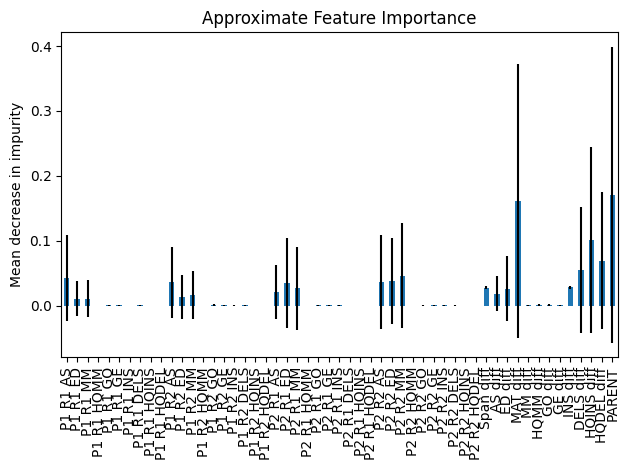

In [17]:
importances = rfc_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc_model.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_names)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Approximate Feature Importance")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [18]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(forest_importances)

P1 R1 AS       0.042025
P1 R1 ED       0.011027
P1 R1 MM       0.010730
P1 R1 HQMM     0.000000
P1 R1 GO       0.000349
P1 R1 GE       0.000448
P1 R1 INS      0.000248
P1 R1 DELS     0.000326
P1 R1 HQINS    0.000000
P1 R1 HQDEL    0.000000
P1 R2 AS       0.035937
P1 R2 ED       0.013187
P1 R2 MM       0.015966
P1 R2 HQMM     0.000000
P1 R2 GO       0.000515
P1 R2 GE       0.000487
P1 R2 INS      0.000267
P1 R2 DELS     0.000355
P1 R2 HQINS    0.000000
P1 R2 HQDEL    0.000000
P2 R1 AS       0.021014
P2 R1 ED       0.035280
P2 R1 MM       0.026616
P2 R1 HQMM     0.000000
P2 R1 GO       0.000318
P2 R1 GE       0.000465
P2 R1 INS      0.000328
P2 R1 DELS     0.000200
P2 R1 HQINS    0.000000
P2 R1 HQDEL    0.000000
P2 R2 AS       0.036358
P2 R2 ED       0.037978
P2 R2 MM       0.046160
P2 R2 HQMM     0.000000
P2 R2 GO       0.000306
P2 R2 GE       0.000439
P2 R2 INS      0.000327
P2 R2 DELS     0.000224
P2 R2 HQINS    0.000000
P2 R2 HQDEL    0.000000
Span diff      0.027884
AS diff        0

In [19]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    its = forest_importances.sort_values()
    print(its)

P1 R1 HQDEL    0.000000
P2 R1 HQDEL    0.000000
P1 R2 HQMM     0.000000
P2 R2 HQINS    0.000000
P1 R2 HQINS    0.000000
P1 R1 HQINS    0.000000
P1 R2 HQDEL    0.000000
P2 R2 HQMM     0.000000
P2 R1 HQMM     0.000000
P1 R1 HQMM     0.000000
P2 R2 HQDEL    0.000000
P2 R1 HQINS    0.000000
P2 R1 DELS     0.000200
P2 R2 DELS     0.000224
P1 R1 INS      0.000248
P1 R2 INS      0.000267
P2 R2 GO       0.000306
P2 R1 GO       0.000318
P1 R1 DELS     0.000326
P2 R2 INS      0.000327
P2 R1 INS      0.000328
P1 R1 GO       0.000349
P1 R2 DELS     0.000355
P2 R2 GE       0.000439
P1 R1 GE       0.000448
P2 R1 GE       0.000465
P1 R2 GE       0.000487
P1 R2 GO       0.000515
GE diff        0.000539
MM diff        0.000744
GO diff        0.000787
HQMM diff      0.000978
P1 R1 MM       0.010730
P1 R1 ED       0.011027
P1 R2 ED       0.013187
P1 R2 MM       0.015966
AS diff        0.018526
P2 R1 AS       0.021014
ED diff        0.026431
P2 R1 MM       0.026616
Span diff      0.027884
INS diff       0